<div>
  <img style="float: left;"  width="140" src=" 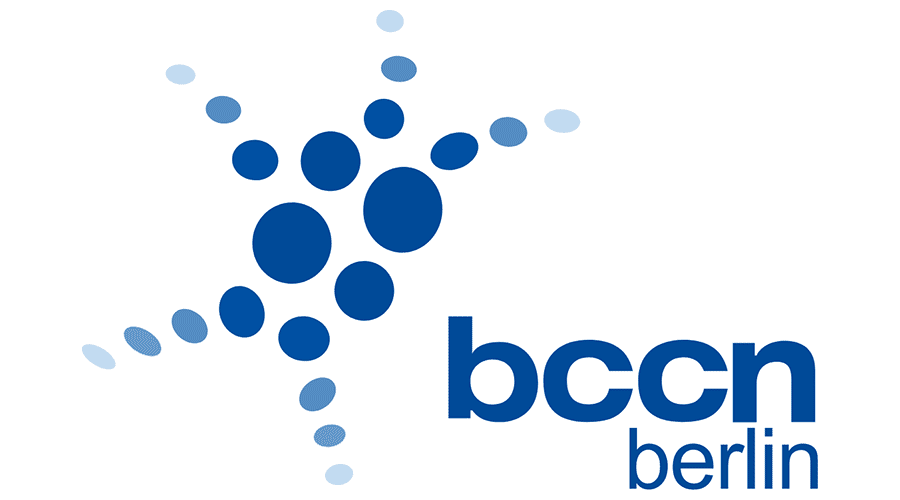">
</div>

<h1 id="course-title-heading">
    <div style="text-align: right">
        Models of Higher Brain Functions
        <br>Computer Course
        <br>
    </div>
</h1>
    
---
<div style="text-align: left; float: left">
    Lecturer: Prof. Dr. Henning Sprekeler
</div>

<div style="text-align: right">
    Assistant: Jarek Liesen
    <br>(jarek@bccn-berlin.de)
</div>



# Deep Q-Learning Project (MHBF)

Names: Ahmed Abdalfatah - Arina Belova
Group: "O"

In [1]:
# Cloning the required files from git directly to avoid pain
!git clone https://github.com/ahmedtarek-/Deep-Q-Learning.git
!cp -r /content/Deep-Q-Learning/gym-grid/gym_grid gym_grid

Cloning into 'Deep-Q-Learning'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 37 (delta 12), reused 26 (delta 7), pack-reused 0
Unpacking objects: 100% (37/37), done.
cp: cannot stat '/content/Deep-Q-Learning/gym-grid/gym_grid': No such file or directory


In [2]:
# Install required packages
!pip install -q gym==0.15.4
!pip install -q pycolab==1.2
!pip install -q torch==1.2.0
#!pip install -q matplotlib==3.1.2

ERROR: Could not find a version that satisfies the requirement torch==1.2.0 (from versions: 1.4.0, 1.5.0, 1.5.1, 1.6.0, 1.7.0, 1.7.1, 1.8.0, 1.8.1, 1.9.0, 1.9.1, 1.10.0, 1.10.1, 1.10.2, 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1)
ERROR: No matching distribution found for torch==1.2.0


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Import required packages
import gym
import gym_grid

import numpy as np
import matplotlib.pyplot as plt
import random
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.optim as optim

from IPython import display

# Part 1 - Environment Implementation

(3, 32, 4)
(6, 14, 5)


/home/galan/anaconda3/envs/rl/lib/python3.8/site-packages/pycolab/ascii_art.py:318: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  art = np.vstack(np.fromstring(line, dtype=np.uint8) for line in art)


(6, 14, 5)

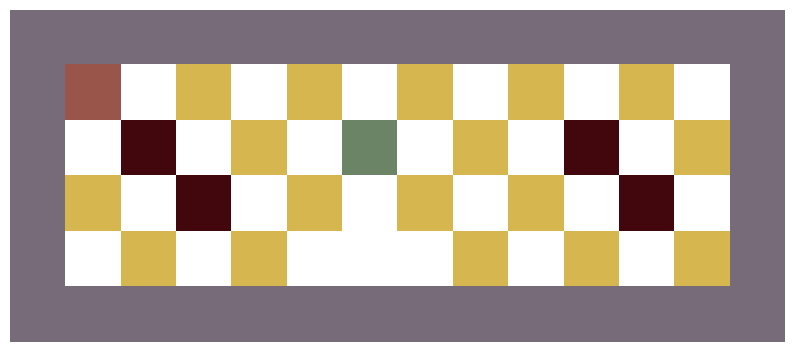

In [2]:
# Visualize the environment
plt.figure(figsize=(10, 10))

# T-Maze Environment
env = gym.make("LinearTrack-v0")
obs, obs_to_render = env.reset_with_render()
print(obs.shape)
env.render(obs_to_render)

# TODO: Deadly Gridworld
env = gym.make("DeadlyGrid-v0")
obs, obs_to_render = env.reset_with_render()
env.render(obs_to_render)
print(obs.shape)

env.observation_space.shape

200
2


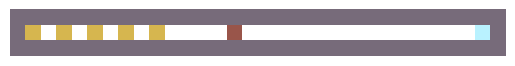

In [5]:
# Run random steps & Visualize the episode
from IPython import display

_, obs_to_render = env.reset_with_render()
env.render(obs_to_render)
rew_total = 0
for i in range(50):
    action = env.action_space.sample()
    _, rew , done, _, obs_to_render = env.step_with_render(action)
    env.render(obs_to_render)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    rew_total += rew
    if done:
        break
print(rew_total)
print(action)

# Part 2 - Deep Q-Learning Agents

In [6]:
# PLAYGROUND CELL
states = env.observation_space.shape
actions = env.action_space.n

env.observation_space.shape

(3, 32, 4)

### 1) Defining Network

In [2]:
random.seed(42)
bs = 128

# Simple MLP class

class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self, dim_input, dim_output):
    super().__init__()

    self.layers = nn.Sequential(OrderedDict([
    ('hidden', nn.Linear(dim_input, 128)),
    ('act', nn.ReLU()),
    ('output', nn.Linear(128, dim_output)),
    # maybe we want this as well ('outact', nn.Sigmoid()),
    ]))

    # init weights, maybe Xavier init?
    self.layers.apply(self.init_weights)

  def init_weights(self, module):
    if isinstance(module, nn.Linear):
      torch.nn.init.xavier_uniform_(module.weight)
      module.bias.data.fill_(0.01)

  def forward(self, x):
      return self.layers(x)

### 2) Defining policy

In [3]:
# TODO: implement annealing epsilon-greedy from 1-> 0

def eps_greedy(q, e):
  rand = np.random.uniform(0, 1)
  if rand <= (1 - e):
    chosen_action = torch.argmax(q).item()
  else:
    chosen_action = np.random.choice(range(len(q)))

  # to avod the warning
  q_value = torch.unsqueeze(q[chosen_action], 0)
  #print(f"Just q value: {q_value}")
  return chosen_action, q_value

### 3) Defining Y_hat

In [4]:
def calculate_y_hat(reward, max_next_q, done, gamma=0.99):
  return torch.Tensor([reward + gamma * (1 - done) * max_next_q])

In [8]:
def rollout_episode(current_state, env, model, policy, episodes_num = 10):
    model.eval()
    rew_total = 0

    for _ in range(episodes_num):
        # use the epsilon greedy policy with a ver small epsilon = 0.01 
        q = model(current_state)    
        action = policy(q, e = 0.01)
        new_state, rew , done, _ = env.step(action)
        rew_total += rew
        current_state = torch.Tensor(new_state.flatten()) 
        
        if done:
            break
      
    model.train() 
    return rew_total       

### 2) Defining main loop

In [11]:
# https://spinningup.openai.com/en/latest/algorithms/ddpg.html
# http://karpathy.github.io/2016/05/31/rl/
# https://towardsdatascience.com/deep-deterministic-policy-gradients-explained-4643c1f71b2e

def the_loop(model, env, loss_function, num_update_steps = 20000, num_episodes = 50, policy = eps_greedy, evaluate_steps = 500):
  # episodes num = 50/100 and updates = 20000/100000
  #for update_step in range(num_update_steps):
  counter = 0
  while counter < num_update_steps:
    #print(update_step)
    current_state = env.reset()

    for _ in range(num_episodes):
      # TODO: another for loop for batches
    
      # 1. Forward pass on NN to get the Q(t)
      #print(current_state.shape)
      current_state_tensor = torch.Tensor(current_state.flatten())
      q_t = model(current_state_tensor)

      # 2. Decide which action to choose based on annealing epsilon greedy policy
      # TODO: # sigmoid schedule on the epsilon so we have more exploration
      chosen_action, current_q_value = policy(q_t, e = 1 * (1 - ((counter + 1) / num_update_steps)))
      #print(f"Current q value is {current_q_value}")

      # 3. Take action/step and get reward and next state
      next_state, reward , done, _ = env.step(chosen_action)

      # 3(a). Store in experence replay buffer:
      #store_in_experience_replay(current_state_tensor, chosen_action, reward, next_state, done)

      # 4. Run another forward pass to get all q_values for next_state
      next_state_tensor = torch.Tensor(next_state.flatten())

      # TODO: forgot to update current state, so it was learning a lot from the initial state:
      current_state_tensor = next_state_tensor

      q_next_t = model(next_state_tensor)

      # 5. Get maximum q_value, greedy action
      _, next_max_q_value = policy(q_next_t, e=0)
      #next_max_q_value, q_next_t

      # 6. Calculate Y_hat
      y_hat = calculate_y_hat(reward, next_max_q_value, done * 1).detach()
      #print(f"Do we require grad? {y_hat.requires_grad}")

      # 7. Loss function
      loss = loss_function(current_q_value, y_hat)
      #print(current_q_value.type())
      #print(y_hat.type())

      # 8. Backpropagate to learn
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # 9. TODO: Do the evaluation every 500 steps
      # run in the env under greedy policy to get running reward
      if (counter % evaluate_steps) == 0:
        with torch.no_grad():
          rew_intermediate = rollout_episode(current_state_tensor, env, model, policy)  
          print(f"Intermediate reward after {counter} update is {rew_intermediate}")  

      # step counter
      counter +=1

      # 10. Check if we terminate an episode due to one of the termination conditions
      if done:
        break

      # 11. Check if we're out of updating for good.
      if counter >= num_update_steps:
        break

      # YAAAY repeat now

**Questions:**

 - Linearly Annealing epsilon greedy poicy
 - Correctness of termination condition
 - MSBE loss looks like MSE loss between current state and update. Yes it is the same


In [10]:
env = gym.make("LinearTrack-v0")

states = np.prod(env.observation_space.shape)
actions = env.action_space.n

lr = 0.001
model = MLP(states, actions)

# Defining the loss function
loss_func = nn.MSELoss()

# Defining optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

the_loop(model, env, loss_func)

# Save the model weights
# torch.save(model.state_dict(), "models/vanilla_linear_track.pt")

/home/galan/anaconda3/envs/rl/lib/python3.8/site-packages/pycolab/ascii_art.py:318: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  art = np.vstack(np.fromstring(line, dtype=np.uint8) for line in art)


Intermediate reward after 1 update is 0
Intermediate reward after 501 update is 0
Intermediate reward after 1001 update is 0
Intermediate reward after 1501 update is 0
Intermediate reward after 2001 update is 0


RuntimeError: play() was called after the episode handled by this Engine has terminated.

In [10]:
def load_model_env(env, path_to_model):
    states = np.prod(env.observation_space.shape)
    actions = env.action_space.n

    m_load = MLP(states, actions) 
    m_load.load_state_dict(torch.load(path_to_model))

    return m_load

In [13]:
m_gold = load_model_env(env, "models/vanilla_linear_track_upd.pt")

In [14]:
m_diamond = load_model_env(env, "models/vanilla_linear_track_diamond.pt")

In [11]:
def run_trained_model_visual(env, model, num_steps = 20):
    current_state, obs_to_render = env.reset_with_render()
    env.render(obs_to_render)
    rew_total = 0

    # put the model in inference mode
    model.eval()
    done = False 

    for _ in range(num_steps):
        action = torch.argmax(model(torch.Tensor(current_state.flatten()))).item()    
        current_state, rew , done, _, obs_to_render = env.step_with_render(action)
        env.render(obs_to_render)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        rew_total += rew

        if done:
            break
        
    print(f"The total reward in this episode is: {rew_total}")

The total reward in this episode is: 700


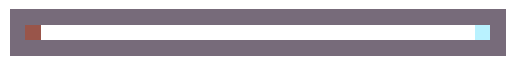

In [25]:
run_trained_model_visual(env, m_gold)

The total reward in this episode is: 10000


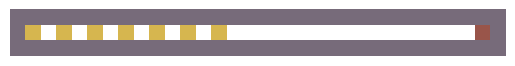

In [16]:
run_trained_model_visual(env, m_diamond)

Note for the report:

This weird behaviour of aquiring a diamond was due to the fact that the model was updating its gradient for 20000 * 50 times instead of just 20000.
And consequently, it took almost eternity to do so:) 

# Ideas: 

In the definition of environment:
- Create a small negative reward (-10) for every step taken
- Create a negative reward (-100) for the wall hitting 

### Deadly grid

In [17]:
env_grid = gym.make("DeadlyGrid-v0")

In [18]:
states_grid = np.prod(env_grid.observation_space.shape)
actions_grid = env_grid.action_space.n

lr = 0.001
model = MLP(states_grid, actions_grid)

# Defining the loss function
loss_func = nn.MSELoss()

# Defining optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#print(model.layers[2].weight)
the_loop(model, env_grid, loss_func, num_update_steps = 100000, num_episodes = 100)
#print(model.layers[2].weight)

# Save the model weights
torch.save(model.state_dict(), "models/vanilla_2d_track.pt")

The total reward in this episode is: 500


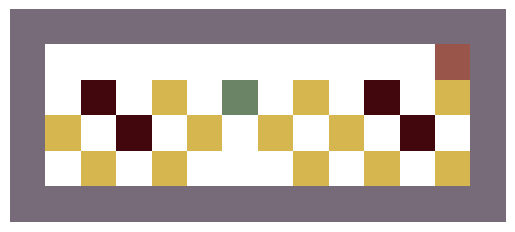

In [35]:
m_grid = load_model_env(env_grid, "models/vanilla_2d_track.pt")
run_trained_model_visual(env_grid, m_grid)

# Experience replay:

Let's add experience replay to this dumb agent above in hope that it will remember some cool transitions from the past: